In [ ]:
## MTL (Multi-Task Learning)
#reference: https://nixtlaverse.nixtla.io/neuralforecast/models.tsmixer.html

Based on the search results, I can provide you with information about multi-task learning in the context of Nixtla's forecasting libraries.

**Multi-task learning** in time series forecasting refers to training models on multiple time series simultaneously to leverage shared patterns and improve overall performance. Here's what Nixtla offers:

## Global Models (Multi-Task Learning)

**NeuralForecast** implements global models that train on multiple time series simultaneously:

- All NeuralForecast models are "global" - they train on all series in your dataset using shared parameters
- This approach is called "cross-learning" and is common practice for deep learning forecasting models
- Models like **AutoNHITS**, **AutoLSTM**, **TSMixer**, and **TimeLLM** can handle multiple time series efficiently

## Key Approaches:

1. **Multiple Series Training**: Train one model across many time series to capture shared patterns
2. **Multivariate Forecasting**: Use information from multiple related time series (like TSMixer models)
3. **Automatic Model Selection**: Use Auto models to find the best configuration across multiple series

## Benefits:

- **Better Performance**: Shared learning across series often improves accuracy
- **Efficiency**: One model handles many series instead of training separate models
- **Scalability**: Can handle large numbers of time series efficiently

The documentation shows examples of training models on datasets with multiple time series (like the M4 competition data) where a single model learns patterns across all series simultaneously.

```suggestions
(End to End Walkthrough)[/neuralforecast/docs/tutorials/getting_started_complete.html]
(Multivariate Forecasting with TSMixer)[/neuralforecast/docs/tutorials/multivariate_tsmixer.html]
(Multiple series forecasting)[/nixtla/docs/tutorials/multiple_series.html]
```

In [ ]:
%%capture
!pip install statsforecast
!pip install mlforecast
!pip install utilsforecast
!pip install tsfeatures
!pip install squarify

!pip install neuralforecast datasetsforecast


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

# You can modify this to improve aesthetics
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 4)
np.set_printoptions(suppress=True)

In [ ]:
#introduce exports data
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv',
                         parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)
DAT_Export

def calculate_yoy_growth(df, periods=12):
    df_transformed = df.copy()
    df_transformed['y'] = df_transformed.groupby('unique_id')['y'].pct_change(periods=periods) * 100
    return df_transformed.dropna()

#DAT_Export = calculate_yoy_growth(DAT_Export)
#DAT_Export


In [71]:
#add calendar features
from utilsforecast.feature_engineering import trend, fourier, pipeline
from functools import partial

features = [trend,
            partial(fourier, season_length=12, k=4)
            ]
df_train_aug, future_predictors = pipeline(DAT_Export,
                                           features=features,
                                           freq="MS",
                                           h=4)
Y_df = df_train_aug.copy()
Y_df

,ds,unique_id,y,trend,sin1_12,sin2_12,sin3_12,sin4_12,cos1_12,cos2_12,cos3_12,cos4_12
0,2010-01-01,AUS,618.5383,1.0,5.0000e-01,8.6603e-01,1.0000e+00,8.6603e-01,8.6603e-01,0.5,-4.3711e-08,-0.5
1,2010-02-01,AUS,613.9709,2.0,8.6603e-01,8.6603e-01,-8.7423e-08,-8.6603e-01,5.0000e-01,-0.5,-1.0000e+00,-0.5
2,2010-03-01,AUS,699.7702,3.0,1.0000e+00,-8.7423e-08,-1.0000e+00,1.7485e-07,-4.3711e-08,-1.0,1.1925e-08,1.0
3,2010-04-01,AUS,769.3857,4.0,8.6603e-01,-8.6603e-01,1.7485e-07,8.6603e-01,-5.0000e-01,-0.5,1.0000e+00,-0.5
4,2010-05-01,AUS,829.4839,5.0,5.0000e-01,-8.6603e-01,1.0000e+00,-8.6603e-01,-8.6603e-01,0.5,-3.3777e-07,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
3289,2024-11-01,VNM,1886.1228,179.0,-5.0000e-01,-8.6602e-01,-1.0000e+00,-8.6603e-01,8.6603e-01,0.5,3.8904e-06,-0.5
3290,2024-12-01,VNM,1981.8492,180.0,2.3850e-07,4.7700e-07,8.3449e-06,9.5399e-07,1.0000e+00,1.0,1.0000e+00,1.0
3291,2025-01-01,VNM,1843.3373,181.0,5.0000e-01,8.6602e-01,1.0000e+00,8.6603e-01,8.6603e-01,0.5,-1.2799e-05,-0.5
3292,2025-02-01,VNM,1717.4660,182.0,8.6603e-01,8.6602e-01,-1.7254e-05,-8.6604e-01,4.9999e-01,-0.5,-1.0000e+00,-0.5


In [72]:
n_time = len(Y_df.ds.unique())
n_series = len(Y_df.unique_id.unique())
horizon  = 6
val_size = 12
test_size = 12
# val_size = 12#int(.2 * n_time)
# test_size = 12#int(.2 * n_time)

In [78]:
#template
if False:
    from ray import tune
    from ray.tune.search.hyperopt import HyperOptSearch
    from neuralforecast import NeuralForecast
    from neuralforecast.auto import AutoTSMixer
    from neuralforecast.losses.pytorch import MAE

    # Define hyperparameter search space
    config = {
        "input_size": tune.choice([24, 48, 96]),
        "max_steps": tune.choice([500, 1000, 2000]),
        "val_check_steps": 100,
        "early_stop_patience_steps": 5,
        "learning_rate": tune.loguniform(1e-4, 1e-2),
        "n_block": tune.choice([1, 2, 4, 6, 8]),
        "dropout": tune.uniform(0.0, 0.99),
        "ff_dim": tune.choice([32, 64, 128]),
        "scaler_type": 'identity',
    }

    # Instantiate AutoTSMixer
    model = AutoTSMixer(
        h=12,                           # Forecast horizon
        n_series=2,                     # Number of time series
        loss=MAE(),                     # Training loss
        config=config,                  # Hyperparameter search space
        num_samples=10,                 # Number of configurations to explore
        search_alg=HyperOptSearch(),    # Search algorithm
        backend='ray',                  # Backend for optimization
        valid_loss=MAE()               # Validation loss
    )

    # Create NeuralForecast object
    nf = NeuralForecast(models=[model], freq='M')

    # Fit the model (this will perform hyperparameter tuning)
    nf.fit(df=Y_df, val_size=12)

    # Make predictions
    forecasts = nf.predict()

18

In [103]:
#Train the models
import logging
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate
from neuralforecast.auto import AutoTSMixer
from neuralforecast.losses.pytorch import MAE

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTSMixer
from neuralforecast.losses.pytorch import MAE



logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

input_size = 12#512 #lag
max_steps = 200
step=3
val_check_steps = 20

config = {
    "input_size": tune.choice([24, 48, 96]),
    "max_steps": tune.choice([500, 1000, 2000]),
    "val_check_steps": 100,
    "early_stop_patience_steps": 5,
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "n_block": tune.choice([1, 2, 4, 6, 8]),
    "dropout": tune.uniform(0.0, 0.99),
    "ff_dim": tune.choice([32, 64, 128]),
    "scaler_type": 'identity',
}

models = [
        #   TSMixer(h=horizon,
        #         input_size=input_size,
        #         n_series=n_series,
        #         max_steps=max_steps,
        #         val_check_steps=20,
        #         early_stop_patience_steps=5,
        #         scaler_type='identity',
        #         valid_loss=MAE(),
        #         random_seed=42,
        #         #dropout = 0.7,
        #         #learning_rate = 1e-2,
        #         ),
        #   AutoTSMixer(
        #         h=horizon,                           # Forecast horizon
        #         n_series=n_series,                     # Number of time series
        #         loss=MAE(),                     # Training loss
        #         config=config,                  # Hyperparameter search space
        #         num_samples=10,                 # Number of configurations to
        #         search_alg=HyperOptSearch(),
        #         backend='ray',                  # Backend for optimization
        #         valid_loss=MAE(),               # Validation loss
        #     ),
        #    AutoTSMixer(h=horizon,
        #         n_series=n_series,
        #         loss=MAE(),
        #         #config=config,
        #         num_samples=10,
        #         backend='optuna',
        #         valid_loss=MAE(),
        #     ),
        #   TSMixerx(h=horizon,
        #         input_size=input_size,
        #         n_series=n_series,
        #         max_steps=max_steps,#1000,
        #         val_check_steps=val_check_steps,#100,
        #         early_stop_patience_steps=5,
        #         scaler_type='identity',
        #         dropout=0.7,
        #         valid_loss=MAE(),
        #         random_seed=42,#12345678,
        #         futr_exog_list=['trend', 'sin1_4', 'sin2_4', 'cos1_4','cos2_4'],
        #         ),

        #   MLPMultivariate(h=horizon,
        #         input_size=input_size,
        #         n_series=n_series,
        #         hidden_size=256,
        #         valid_loss=MAE(),
        #         random_seed=42,
        #         ),

        #    NHITS(h=horizon,
        #         input_size=horizon,
        #         max_steps=max_steps,#1000,
        #         val_check_steps=val_check_steps,#100,
        #         #early_stop_patience_steps=5,
        #         scaler_type='robust',
        #         valid_loss=MAE(),
        #         random_seed=42,
        #        ),

        ]

In [104]:
nf = NeuralForecast(
    models=models,
    freq='MS',
)

Y_hat_df = nf.cross_validation(
    df=Y_df,
    val_size=val_size,
    step_size=12,
    n_windows=4,
    #step_size = step,
)

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-08-18_14-43-26   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-08-18_14-43-26
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-08-18_14-10-05_102958_129/artifacts/2025-08-18_14-43-26/_train_tune_2025-08-18_14-43-26/driver_artifacts`


2025-08-18 14:48:36,696	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-08-18 14:48:36,703	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-08-18_14-43-26' in 0.0062s.
2025-08-18 14:48:36,707	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/root/ray_results/_train_tune_2025-08-18_14-43-26", trainable=...)
2025-08-18 14:48:36,710	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- _train_tune_98584775: FileNotFoundError('Could not fetch metrics for _train_tune_98584775: both result.json and progress.csv were not found at /root/ray_results/_train_tune_2025-08-18_14-43-26/_train_tune_98584775_1_dropout=0.6395,early_stop_patience_ste

TypeError: neuralforecast.models.tsmixer.TSMixer() argument after ** must be a mapping, not NoneType

In [ ]:
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTSMixer
from neuralforecast.losses.pytorch import MAE

# Define hyperparameter search space
config = {
    "input_size": tune.choice([24, 48, 96]),
    "max_steps": tune.choice([500, 1000, 2000]),
    "val_check_steps": 100,
    "early_stop_patience_steps": 5,
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "n_block": tune.choice([1, 2, 4, 6, 8]),
    "dropout": tune.uniform(0.0, 0.99),
    "ff_dim": tune.choice([32, 64, 128]),
    "scaler_type": 'identity',
}

# Instantiate AutoTSMixer
model = AutoTSMixer(
    h=12,                           # Forecast horizon
    n_series=2,                     # Number of time series
    loss=MAE(),                     # Training loss
    config=config,                  # Hyperparameter search space
    num_samples=10,                 # Number of configurations to explore
    search_alg=HyperOptSearch(),    # Search algorithm
    backend='ray',                  # Backend for optimization
    valid_loss=MAE()               # Validation loss
)

# Create NeuralForecast object
nf = NeuralForecast(models=[model], freq='M')

# Fit the model (this will perform hyperparameter tuning)
nf.fit(df=Y_df, val_size=12)

# Make predictions
forecasts = nf.predict()



/tmp/ipython-input-1986758182.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


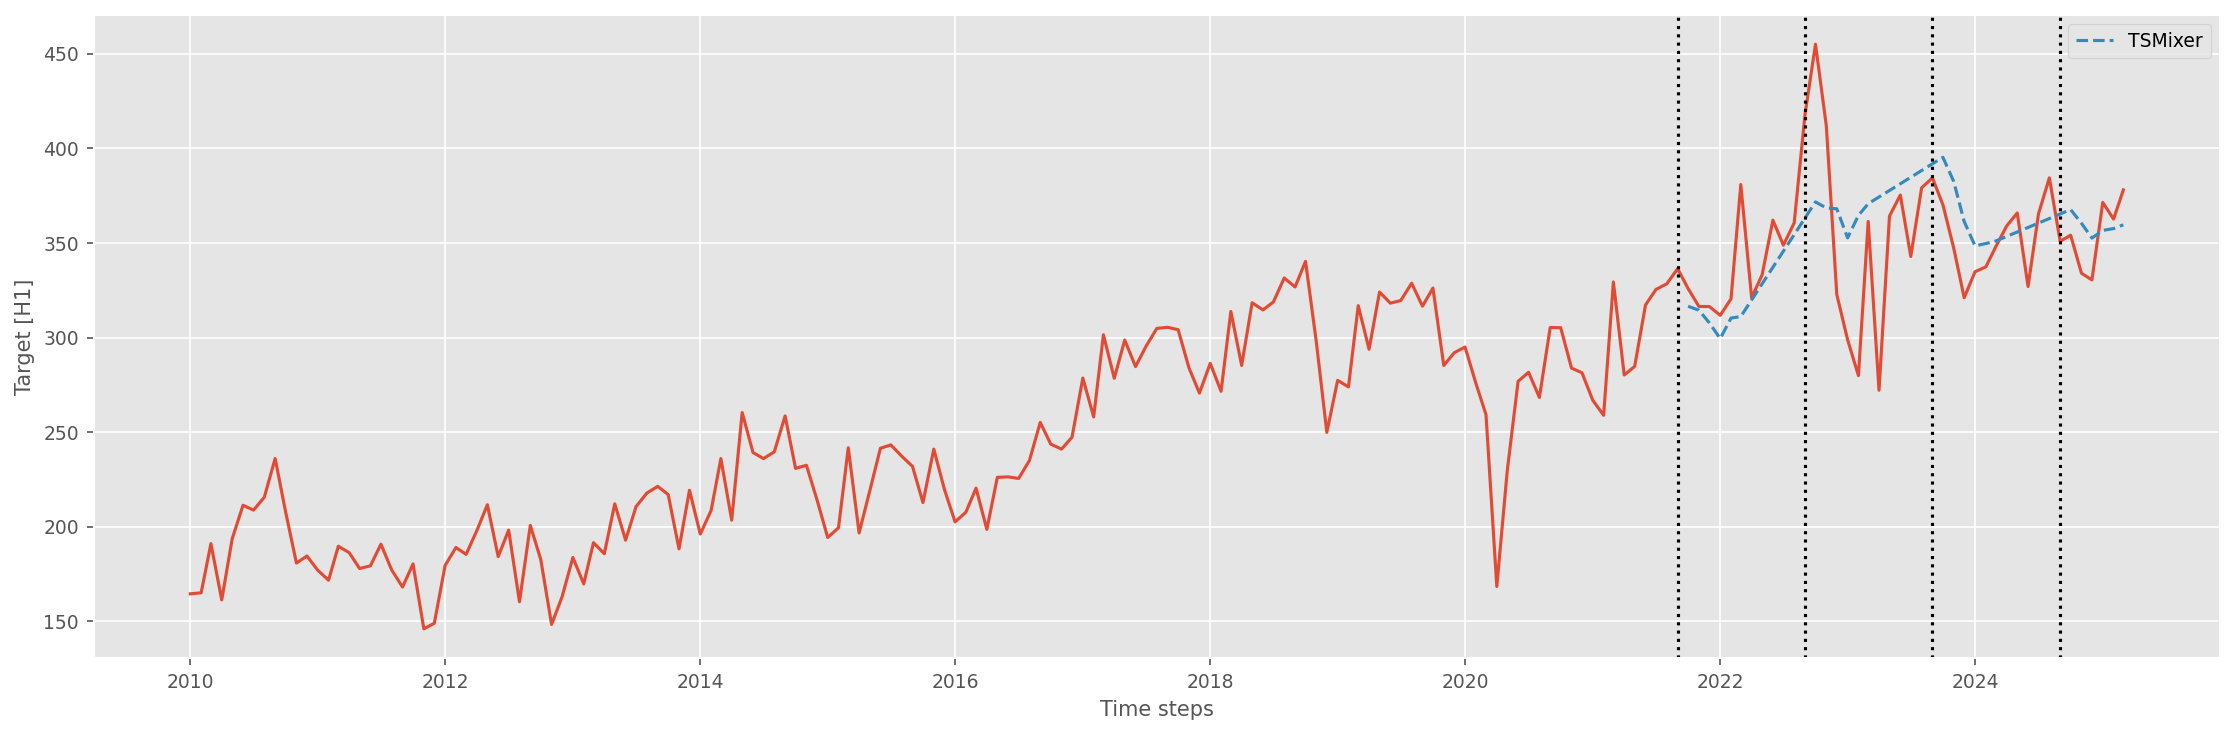

In [ ]:
cutoffs = Y_hat_df['cutoff'].unique()

Y_hat_dfi = Y_hat_df.query("unique_id == 'PHL'")
Y_dfi = Y_df.query("unique_id == 'PHL'")

plt.figure(figsize=(15,5))
plt.plot(Y_dfi['ds'], Y_dfi['y'])
plt.plot(Y_hat_dfi['ds'], Y_hat_dfi['TSMixer'], label='TSMixer', ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()

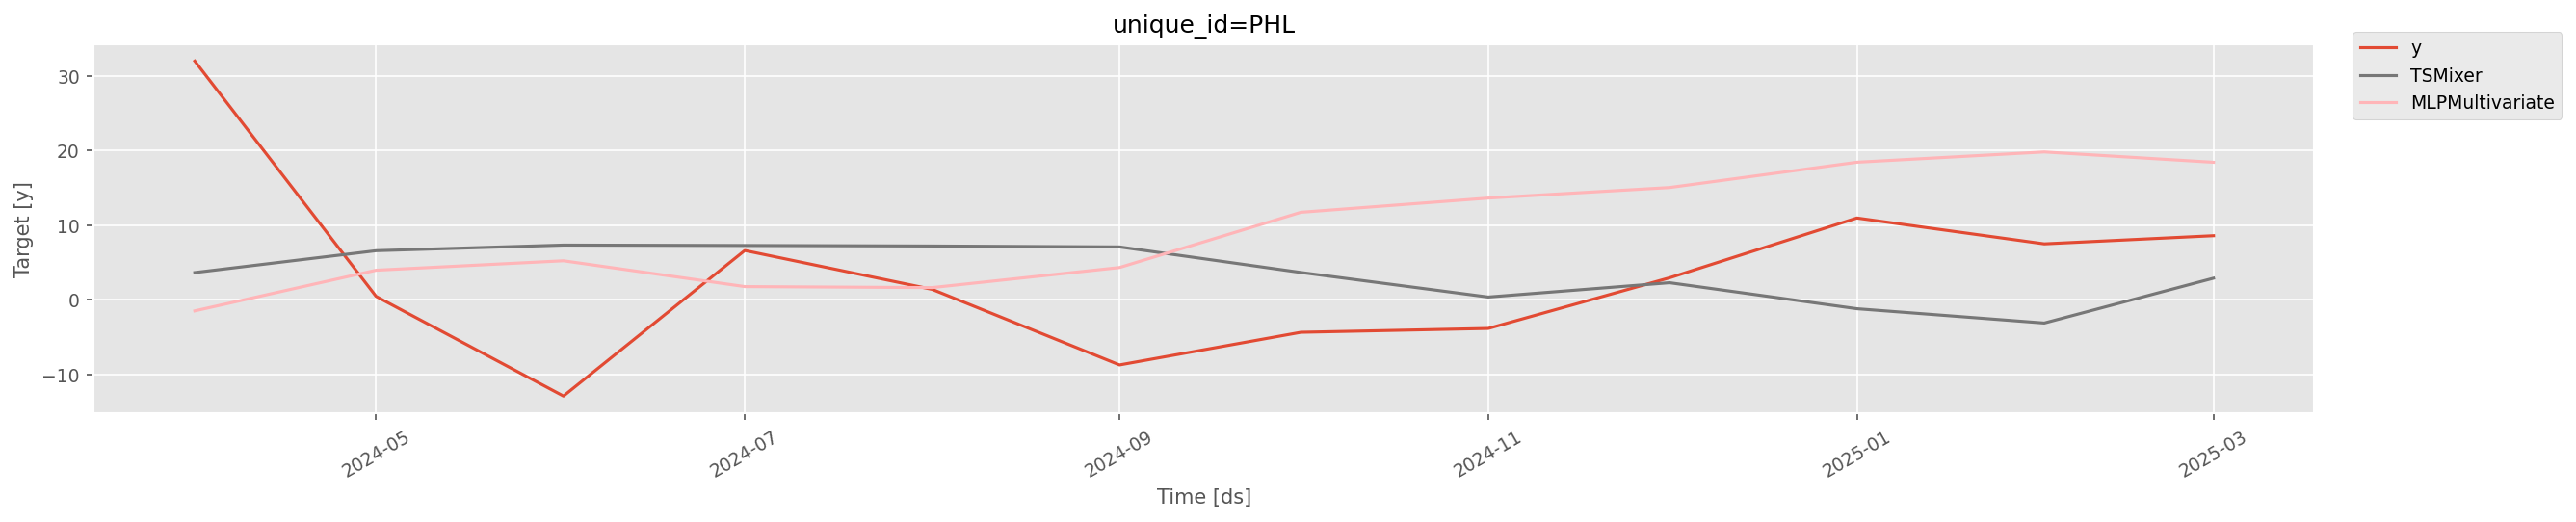

In [ ]:
from utilsforecast.plotting import plot_series

cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_hat_df[Y_hat_df['cutoff'].isin(cutoffs)].drop(columns='cutoff')
plot_series(forecasts_df=Y_plot, ids=['PHL'])

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse

evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df.unique_id == 'PHL'], metrics=[mae, rmse], agg_fn='mean').T



,0,1
metric,mae,rmse
TSMixer,10.3437,12.8456
MLPMultivariate,21.6075,23.8071


In [ ]:
Y_hat_df[Y_hat_df['cutoff'].isin(cutoffs)]

,unique_id,ds,cutoff,TSMixer,MLPMultivariate,y
0,AUS,2024-04-01,2024-03-01,-4.0959,-5.2156,-6.6125
1,AUS,2024-05-01,2024-03-01,-2.4540,-6.3631,-6.8171
2,AUS,2024-06-01,2024-03-01,-1.4068,-6.1546,-1.5482
3,AUS,2024-07-01,2024-03-01,-5.8858,-6.3660,2.3315
4,AUS,2024-08-01,2024-03-01,-3.0021,-3.2264,-4.9983
...,...,...,...,...,...,...
751,VNM,2024-11-01,2024-09-01,12.8090,20.5489,11.3191
752,VNM,2024-12-01,2024-09-01,14.3956,25.4947,15.3550
753,VNM,2025-01-01,2024-09-01,11.4781,22.9904,-2.6239
754,VNM,2025-02-01,2024-09-01,12.8536,24.1197,26.9451
